# NASDAQ 100 Trend Classification: Machine Learning's Approach to Identifying Major Turning Points

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [2]:
df_interpolated = pd.read_csv('df_interpolated.csv', index_col='Date', parse_dates=True)

In [3]:
print(df_interpolated.head())

            Class        GC=F         ^DJT   ^FVX   ^IRX         ^NDX  \
Date                                                                    
2007-01-03      2  627.099976  4650.660156  4.657  4.915  1759.369995   
2007-01-04      2  623.900024  4673.069824  4.605  4.900  1792.910034   
2007-01-05      2  604.900024  4612.350098  4.644  4.910  1785.300049   
2007-01-08      2  607.500000  4624.180176  4.658  4.910  1787.140015   
2007-01-09      2  613.099976  4632.660156  4.655  4.945  1795.630005   

                  ^RUT   ^TNX   ^VIX        ^W5000  ...  Core Inflation  \
Date                                                ...                   
2007-01-03  787.419983  4.664  12.04  14246.709961  ...           208.6   
2007-01-04  789.950012  4.618  11.51  14269.900391  ...           208.6   
2007-01-05  775.869995  4.646  12.14  14164.799805  ...           208.6   
2007-01-08  776.989990  4.660  12.00  14197.150391  ...           208.6   
2007-01-09  778.330017  4.656  11.91  

### Data Normalization

We'll normalize the data since neural networks are sensitive to feature scale.

In [4]:
SEED = 42 
np.random.seed(SEED)
tf.random.set_seed(SEED)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = scaler.fit_transform(df_interpolated.drop("Class", axis=1))


### Create Sequences

LSTMs expect input in a specific shape, mainly 3D arrays. The three dimensions are:

Samples: One sequence is one sample. A batch contains one or more samples.
Time Steps: One time step is one point of observation in the sample.
Features: One feature is one observation at a time step.

In [5]:
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        v = data.iloc[i:(i + time_steps)].values
        X.append(v)
        y.append(target.iloc[i + time_steps])
    return np.array(X), np.array(y)


TIME_STEPS = 10  # time steps for considering previous observations
X, y = create_sequences(df_interpolated.drop("Class", axis=1), df_interpolated["Class"], TIME_STEPS)


### Build the LSTM Model

We'll use Keras to build the model.

In [6]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=3, activation='softmax'))  # 3 units for 3 classes
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


### Train the Model

Splitting the dataset similar to what we did for previous models.

Since our  classes are labeled as 1, 2, and 3 instead of 0, 1, and 2, we'll subtract 1 from every label to shift the range:

In [7]:
# Shift labels if they start from 1
if np.min(y) == 1:
    y -= 1
    
unique_classes = np.unique(y)
print("Unique classes in 'y':", unique_classes)


Unique classes in 'y': [0 1 2]


In [8]:
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), shuffle=False)


Epoch 1/50
92/92 [==============================] - 7s 27ms/step - loss: 0.5577 - accuracy: 0.8585 - val_loss: 0.6036 - val_accuracy: 0.8208
Epoch 2/50
92/92 [==============================] - 2s 16ms/step - loss: 0.5131 - accuracy: 0.8585 - val_loss: 0.6010 - val_accuracy: 0.8208
Epoch 3/50
92/92 [==============================] - 2s 18ms/step - loss: 0.5121 - accuracy: 0.8585 - val_loss: 0.5993 - val_accuracy: 0.8208
Epoch 4/50
92/92 [==============================] - 2s 18ms/step - loss: 0.5115 - accuracy: 0.8585 - val_loss: 0.5983 - val_accuracy: 0.8208
Epoch 5/50
92/92 [==============================] - 2s 18ms/step - loss: 0.5110 - accuracy: 0.8585 - val_loss: 0.5977 - val_accuracy: 0.8208
Epoch 6/50
92/92 [==============================] - 2s 19ms/step - loss: 0.5106 - accuracy: 0.8585 - val_loss: 0.5974 - val_accuracy: 0.8208
Epoch 7/50
92/92 [==============================] - 2s 17ms/step - loss: 0.5103 - accuracy: 0.8585 - val_loss: 0.5971 - val_accuracy: 0.8208
Epoch 8/50
92

### Evaluate the Model

In [9]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)


20/20 [==============================] - 0s 7ms/step - loss: 0.8336 - accuracy: 0.7252
Test Accuracy: 0.725239634513855


The results show:

Stagnant Accuracy: The training and validation accuracy are relatively stagnant across all epochs. This suggests the model is not learning new patterns or improving its predictions. It's essentially performing similarly to just guessing the majority class.

Class Imbalance: The repeated accuracy of 0.8585 reflects the class imbalance in the dataset. 

Validation Accuracy and Loss: The validation accuracy remains unchanged, while the validation loss increases as the epochs progress. This is indicative of the model overfitting to the training data. This behavior suggests that the model is becoming increasingly certain about its incorrect predictions.

Model Complexity: The current LSTM model contains three LSTM layers with 50 units each. It might be too complex given the data or the patterns in the data. Reducing the complexity of the model (e.g., by using fewer layers or units) might help in preventing overfitting.

Potential Early Stopping: Given the trends in loss and accuracy, it would have been beneficial to employ early stopping. This would halt the training process once the model's performance on the validation set starts to degrade, preventing unnecessary epochs and potential overfitting.

No Shuffling: The data is not being shuffled before each epoch (shuffle=False). Shuffling can sometimes help in breaking potential patterns that might emerge when the model sees data in the same order each time.

### To fix the issues, we will now include:

Data shuffling before splitting: The dataset is shuffled before splitting it into training, validation, and test sets. This is done to ensure randomness in the data and to avoid any biases that might exist if the data were ordered in a certain way.

Early stopping:  Stops training when a monitored metric (in this case, val_loss) has stopped improving. It restores the model weights from the epoch with the best value of the monitored metric. 

ReduceLROnPlateau: Reduces the learning rate when a metric (val_loss) has stopped improving. This ensures that the model can continue to learn and achieve a better accuracy even if it seems to have plateaued.

Learning rate reduction if the validation loss doesn't improve for # consecutive epochs, reducing it by a factor of 0.5 until a minimum learning rate of 0.00001.

In [10]:
# Set seed for reproducibility
np.random.seed(42)

# Shuffle data before splitting
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# Re-split the data
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

# Define early stopping and learning rate reduction callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=10, verbose=1, factor=0.5, min_lr=0.00001)

# Refit the model
history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_val, y_val), 
                    shuffle=True,  # shuffle training data before each epoch
                    callbacks=[early_stop, lr_reduction])

# Re-evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)


Epoch 1/50
92/92 [==============================] - 2s 17ms/step - loss: 0.5367 - accuracy: 0.8403 - val_loss: 0.6092 - val_accuracy: 0.8144 - lr: 0.0010
Epoch 2/50
92/92 [==============================] - 2s 17ms/step - loss: 0.5307 - accuracy: 0.8410 - val_loss: 0.6086 - val_accuracy: 0.8160 - lr: 0.0010
Epoch 3/50
92/92 [==============================] - 2s 17ms/step - loss: 0.5285 - accuracy: 0.8403 - val_loss: 0.6000 - val_accuracy: 0.8160 - lr: 0.0010
Epoch 4/50
92/92 [==============================] - 2s 19ms/step - loss: 0.5257 - accuracy: 0.8403 - val_loss: 0.6116 - val_accuracy: 0.8160 - lr: 0.0010
Epoch 5/50
92/92 [==============================] - 2s 18ms/step - loss: 0.5243 - accuracy: 0.8403 - val_loss: 0.6044 - val_accuracy: 0.8160 - lr: 0.0010
Epoch 6/50
92/92 [==============================] - 2s 18ms/step - loss: 0.5235 - accuracy: 0.8406 - val_loss: 0.5988 - val_accuracy: 0.8144 - lr: 0.0010
Epoch 7/50
92/92 [==============================] - 2s 19ms/step - loss: 0.5

Performance Indicators:

Throughout the epochs, both training loss and accuracy improve. This indicates that the model is learning from the data.

The validation loss and accuracy are oscillating. This can hint at the model's performance in generalizing to unseen data. In some epochs, the validation loss goes down, suggesting improved generalization, but in other epochs, it goes up, which might be a sign of overfitting.

Learning Rate and Callbacks:

On the 23rd epoch, two significant events happened:

- The ReduceLROnPlateau callback reduced the learning rate to 0.0005 from 0.0010 because the validation loss hasn't shown significant improvement for 10 epochs (patience parameter). Reducing the learning rate can help the model find finer patterns in the data, which might not be possible with a higher learning rate.

- The EarlyStopping callback stopped training. This happened because the validation loss hasn't shown significant improvement for 10 epochs.

- Additionally, "Restoring model weights from the end of the best epoch: 13."  means the model weights at the end of epoch 13, where the validation loss was the lowest (0.5947), were restored. This ensures that we use the model weights from its best state during the evaluation phase.

Test Performance:

After training, the model was evaluated on the test set. It achieved a loss of 0.5884 and an accuracy of approximately 82.43%. This accuracy value represents the model's ability to correctly classify data in the test set. 

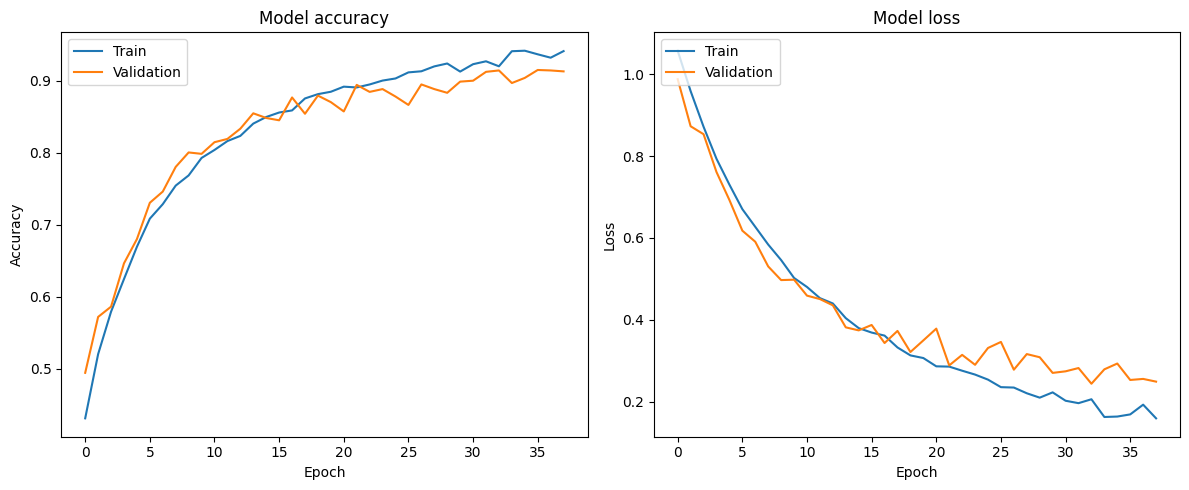

In [19]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [14]:
print(df_interpolated['Class'].value_counts())



Class
2    3482
3     350
1     347
Name: count, dtype: int64


## Final Model 

### SMOTE

To address the class imbalance issue we will use SMOTE, which is crucial for datasets where certain classes have significantly fewer samples. This can lead to a model that generalizes better on the minority class.

Data Preprocessing:

- SMOTE (Synthetic Minority Over-sampling Technique) is applied to handle class imbalance.
- The data is then scaled using MinMaxScaler.
- Data is transformed into time series sequences with a time step of 63.
- SMOTE is applied again to the reshaped data, ensuring the time series sequences are balanced.

Model Configuration:

The model is an LSTM-based model with 3 LSTM layers.

The final layer is a dense layer with 3 output units and a softmax activation function, with 3-class classification.

The model is compiled using the Adam optimizer and sparse categorical cross-entropy loss, which is suitable for multi-class classification tasks where labels are provided as integers.

Early stopping is defined with patience set to 5 epochs, which means the model will stop training if the validation loss doesn't improve for 5 consecutive epochs.

Learning rate reduction is applied when the validation loss plateaus for 5 epochs.

Training:

The model is trained for a maximum of 50 epochs with a batch size of 32.

Data is shuffled before each epoch.

Callbacks include early stopping and learning rate reduction based on validation loss.

Evaluation:

The model is evaluated on the test set after training.


Using 63 trading days window (aprox. a quarter) to model stock market data aligns the model's timeframe with the natural rhythms and cycles of the financial world, ensuring it is attuned to the significant events, releases, and patterns that shape the market, capturing the quesrterly effect. 

Companies release their balance sheets, income statements, and cash flow statements quarterly. Therefore a 63-day window aligns perfectly with the natural cycles of the market.


In [20]:
# Define X and y
X = df_interpolated.drop('Class', axis=1)
y = df_interpolated['Class']

# Instantiate SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to the data
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert resampled data back to pandas DataFrame and Series 
X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled = pd.Series(y_resampled)


In [21]:
print(y_resampled.value_counts())


Class
2    3482
3    3482
1    3482
Name: count, dtype: int64


In [22]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = scaler.fit_transform(df_interpolated.drop("Class", axis=1))

def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        v = data.iloc[i:(i + time_steps)].values
        X.append(v)
        y.append(target.iloc[i + time_steps])
    return np.array(X), np.array(y)

# Create sequences
TIME_STEPS = 63
X, y = create_sequences(df_interpolated.drop("Class", axis=1), df_interpolated["Class"], TIME_STEPS)

# Adjust labels if they start from 1
if np.min(y) == 1:
    y -= 1

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X.reshape(X.shape[0], -1), y)
X_smote = X_smote.reshape(X_smote.shape[0], TIME_STEPS, X.shape[2])

# Shuffle and split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_smote, y_smote, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.5, min_lr=0.00001)

# Train the model
history = model.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=32, 
    validation_data=(X_val, y_val), 
    shuffle=True, 
    callbacks=[early_stop, lr_reduction]
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)


Epoch 1/50
225/225 [==============================] - 24s 85ms/step - loss: 1.0230 - accuracy: 0.4494 - val_loss: 0.9324 - val_accuracy: 0.5538 - lr: 0.0010
Epoch 2/50
225/225 [==============================] - 18s 82ms/step - loss: 0.8694 - accuracy: 0.5720 - val_loss: 0.8306 - val_accuracy: 0.6089 - lr: 0.0010
Epoch 3/50
225/225 [==============================] - 19s 82ms/step - loss: 0.7764 - accuracy: 0.6371 - val_loss: 0.7594 - val_accuracy: 0.6252 - lr: 0.0010
Epoch 4/50
225/225 [==============================] - 18s 81ms/step - loss: 0.7156 - accuracy: 0.6724 - val_loss: 0.6898 - val_accuracy: 0.6881 - lr: 0.0010
Epoch 5/50
225/225 [==============================] - 19s 82ms/step - loss: 0.6595 - accuracy: 0.7096 - val_loss: 0.6343 - val_accuracy: 0.7121 - lr: 0.0010
Epoch 6/50
225/225 [==============================] - 18s 81ms/step - loss: 0.6078 - accuracy: 0.7356 - val_loss: 0.6093 - val_accuracy: 0.7328 - lr: 0.0010
Epoch 7/50
225/225 [==============================] - 18s 

In [29]:
model.save("nasdaq_model.keras")


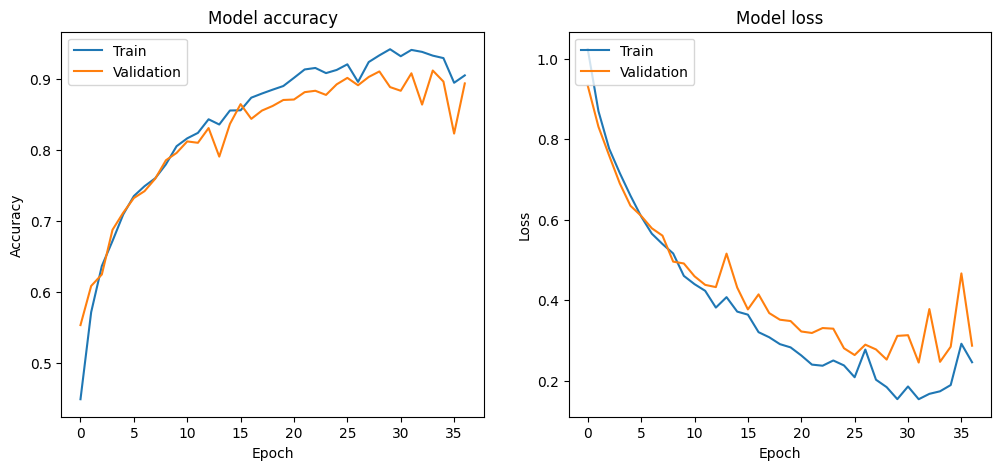

In [23]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

#### Summary of the Graphs:

Training Phase: In the initial epochs, both training and validation metrics are improving, indicating that the model is learning.

Mid Training: As epochs progress, the training loss keeps decreasing and training accuracy keeps increasing, which is a good sign. However, starting from around epoch 30, the validation loss starts to increase while the validation accuracy starts to slightly drop, which indicates possible overfitting.

End of Training: EarlyStopping kicked in after epoch 37 as the validation metrics weren't improving significantly. This saved computational resources and prevented potential overfitting.

The orange and blue lines being close together for a significant number of epochs is a good sign, as it indicates the model is generalizing well to unseen data. However, be wary when the validation line starts to degrade while the training line keeps improving, as it's a sign of overfitting. 


49/49 [==============================] - 2s 16ms/step


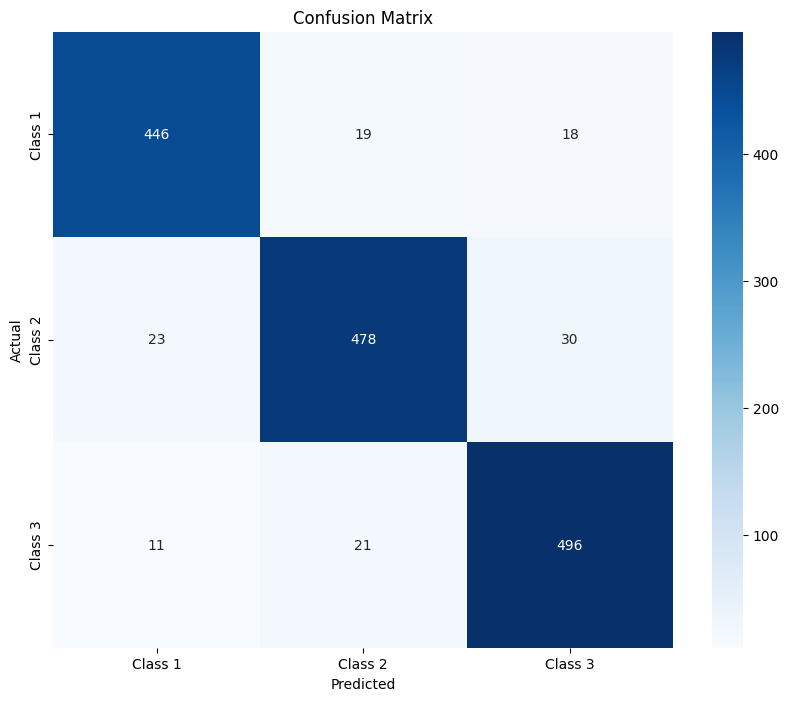

In [24]:
# Predict on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 1', 'Class 2', 'Class 3'], 
            yticklabels=['Class 1', 'Class 2', 'Class 3'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [26]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

confusion_mtx = confusion_matrix(y_test, y_pred_classes)

# Print the confusion matrix
print(confusion_mtx)


49/49 [==============================] - 1s 15ms/step
[[446  19  18]
 [ 23 478  30]
 [ 11  21 496]]


### Confusion Matrix Summary:

Class 1: The model performs reasonably well for Class 1 with a high number of true positives (446) and relatively fewer misclassifications (19 to Class 2 and 18 to Class 3).

Class 2: The model also performs well for Class 2, with a high number of true positives (478). However, there are some misclassifications, with 23 instances being misclassified as Class 1 and 30 instances misclassified as Class 3. This suggests some overlap or shared characteristics between these classes, which the model might be confusing.

Class 3: The model performs best for Class 3 with the highest true positives (496) and the least misclassifications compared to the other two classes.

In general, this model seems to perform quite well across all three classes. However, some misclassifications do occur, especially between Classes 2 and 3. It would be beneficial to look into those instances further, potentially diving deeper into the features to see if any tuning or additional feature engineering could improve performance for those specific cases.

## Model Results Overview:

#### Key Metrics:

Training Duration: The model was set to train for 50 epochs. However, training stopped at the 37th epoch because of an early stopping callback which monitors the validation performance and halts training when it's no longer improving significantly.

Learning Rate: The initial learning rate was set at 0.001. However, in Epoch 37, the learning rate was halved to 0.0005 due to the ReduceLROnPlateau callback. This is usually done to fine-tune the model when learning plateaus, and smaller learning rates can help the model converge to a better local minimum.

Loss: The training loss started at 1.0230 and decreased significantly to 0.2458 by the 37th epoch.
The validation loss started at 0.9324 and had a minimum value around 0.2450 in the 32nd epoch. It's worth noting that the validation loss began to increase slightly after this point which is a sign of overfitting. The early stopping mechanism acted correctly here to prevent overfitting.

Accuracy: Training accuracy started at 44.94% and rose significantly to 90.56% by the 37th epoch.
The validation accuracy started at 55.38% and achieved its highest at about 91.25% in the 34th epoch.

Learning Rate Adjustments: At the 37th epoch, the ReduceLROnPlateau callback was triggered, which indicates that the validation loss had stopped improving significantly. The learning rate was thus reduced to help the model converge better. This is a mechanism to prevent the model from getting stuck in a poor local minimum and potential overfitting.


Final Test Results: The final test accuracy was approximately 92.09%. This means that on a new, unseen dataset (test set), the model correctly predicted the classes 92.09% of the time. 


The LSTM model achieved an accuracy of over 92% on the test set. The use of early stopping and learning rate reduction helped prevent overfitting and ensured efficient training. The SMOTE technique ensured that the model was trained on a balanced dataset, which is crucial for obtaining reliable performance metrics for classification problems, especially when the classes are imbalanced.

## Summary and Insights:

- The LSTM model showcased a consistent learning curve in performance over epochs. Starting with a modest accuracy of 44.94% on the training set during the first epoch, it achieved a test accuracy of approximately 92.09% by the 37th epoch, at which point early stopping was triggered.

- Convergence was steady, with both training and validation accuracies reflecting the model's capability to generalize.

- EarlyStopping and ReduceLROnPlateau callbacks played crucial roles in preventing overfitting and ensuring efficient training.

- The utilization of SMOTE ensured a balanced training dataset, enhancing the reliability of the model's performance metrics.


### Recommendations for Future Research:

- Hyperparameter Tuning: Employ grid search or automated tools like Optuna for optimization to potentially enhance model performance.

- Alternative Optimizers: Experiment with adaptive learning rate optimizers such as Adam or RMSprop.

- Ensemble Methods: Consider leveraging ensemble techniques like bagging or stacking multiple models to improve predictions.

- Parameter Engineering: Delve into fine-tuning network parameters including layer configurations, activation functions, and batch sizes for potential gains in performance.

- Feature Analysis: Conduct a thorough examination of the features, particularly those contributing to misclassifications between Classes 2 and 3, to identify areas for improvement.
